# Graph Neural Networks with attention mechanisms for robot path planning

## Path exploration using GNN

Path planning algorithms is a fundamental problem in autonomous systems. Given a defined environment or map where robotic system navigates, finding a possible path that connects a start with a goal position minimizing a certain heuristic such as distance or energy cost for the robot is considered an optimization problem. Current approaches like RRT or Dijkstra algorithms perform an exploration of the environment sampling states in the environment and dividing them in free or obstacle space states. This exploration of the space requires the distiction of valid or feasible states for a robot, in the case of a single differential robot the exploration space is two dimensional with an orientation consideration (x,y, yaw). The path exploration is done validating the free space states while connecting a tree of possible states until the start and goal positions are connected in the growth tree. The complexity of this tasks becomes time and computational expensive as the dimension of the optimization problem increases. For a manipulator with 7 degrees or freedom or multi-agent systems like 2 robotic arms with 7 degrees of freedom each become expensive and time consuiming to validate the possible position that are feasible to connect the possible states tree. 

The graph and tree structure of the problem make possible to use graph neural networks to optimize the sampling and tree expansion in the path exploration pipeline. The study [1] propose an priority based approach to select the best suitable nodes to perform the state validation and then perform the node expansion. It is proposed a graph neural network that takes the sampled nodes and the graph created using random graph generation RGG with K-NN. The model is using attention mechanisms to learn a representation of the nodes and outputs priority values ${\eta}$ where the node with the maximum probability will be the node to be validated and then explored to grow the tree. The sampling and priority computation is performed for several iterations until the final node is found in the tree or the max iteration constraint is reached. The following pipline describe the path exploration algorithm with priority based node selection.

### Explorer Algorithm

1. Given a start and goal vertex with the obstacles or map data structure, initialize sampling of nodes from the configuration space ${C}$. 

    Sample n nodes from $C_{free}$ and add to free space vertices $V_f$.

    Sample n nodes from $C_{obs}$ and add to free space vertices $V_c$.
    
2. Initialize a graph using K-NN creating edges from the different vertices that exist in the possible nodes $V$.

    $G = \{v:  \{v_s, v_g\} \cup V_f \cup V_c, E: KNN(V_f) \cup KNN(V)  \}$

3. Initialize the nodes tree $V_{{\tau}}$ with the start state and the edges from nodes neighbors using KNN $E$.

    $E_0 = KNN(V_f), V_{{\tau}_0} = \{v_s\}$

4. Start loop computing the first priorities using the explorer model.

    $\eta = N_E(V,E,O)$

5. Repeat from $i=0$ to $MAXITERS$

    - Select edge to explore using the computed priorities $\eta$ and $E_i$
    - Verify that the edge is in the free configuration space, Validation state step

        $e_i : (v_i, v_j) \subseteq C_{free}$

    - Add the node $v_j$ to the exploration tree $V_{{\tau}_{i+1}}$, the edge to exploration edges $E_{{\tau}_{i+1}}$ and the free space edges.

        $E_f(\tau_{i+1}) = \{e_j : (v_i, v_j) \in E_{i+1} | v_i \in V_{{\tau}_{i+1}} , v_j \notin V_{{\tau}_{i+1}}\} $.

    - Check if euclidean distance between $v_j$ and goal vertex $v_g$ is less than a threshold. If yes return the path found $\pi$ on $\tau_i$.
    
    - If the created edges in the computed graph is empty compute new graph and new priorities with explorer model.

        Sample n nodes from $C_{free}$ and $C_{obs}$ creating $V_f$ and $V_c$

        ${V = \{vs, vg\} \cup V_f \cup V_c}$

        $E_i = KNN(V_f)$

        $E = KNN(V_f) \cup KNN(V_c)$

        $\eta = N_E(V,E,O)$

### Explorer Model

The edge exploration priorities is computed using a graph neural network that receives the vertices $V$, edges $E$ and the obstacles $O$. The main objective of the model is to maximize the probability of finding a feasible path $\pi$ adding edges ${e_i}$ from the free space to the expanded tree ${\tau_i}$ on each iteration. 

$e_i = argmax_{e_k \in E_i \cup E_f(\tau_i)} N_E(\eta_k | V,E,O)$

$\{v_i, (v_i - v_g)^2, v_i - v_g\}$


## Model

In [5]:
import torch
import numpy as np
from torch import nn
from torch.nn import BatchNorm1d
from torch_geometric.nn.pool import knn
from torch_geometric.nn.conv import MessagePassing

# Training Packages
import numpy as np
from str2name import str2name 
from train_explorer import train_explorer
from environment import MazeEnv, KukaEnv, Kuka2Env
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Testing Packages
import imageio
from algorithm import NEXT_plan, RRTS_plan
from algorithm.dijkstra import * 
from tqdm import tqdm
import matplotlib.pyplot as plt
from config import set_random_seed
from str2env import str2env
from eval_gnn import explore
from model_smoother import ModelSmoother

In [15]:
class MPNN(MessagePassing):
    def __init__(self, embed_size, aggr: str = 'max', batch_norm: bool = False, **kwards):
        super(MPNN, self).__init__(aggr=aggr, **kwards)
        self.batch_norm = batch_norm
        self.lin_0 = nn.Sequential(
            nn.Linear(embed_size*5, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size)
        )
        self.lin_1 = nn.Linear(embed_size * 2, embed_size)
        self.bn = BatchNorm1d(embed_size)
    
    def forward(self, x, edge_index, edge_attr):
        # propagate_type: (x: PairTensorm, edge_attr:OptTensor)
        out = self.propagate(edge_index, x = (x,x), edge_attr=edge_attr, dim=-1)
        out = self.bn(out) if self.batch_norm else out
        
        return self.lin_1(torch.cat((x, out), dim=-1))
    
    def message(self, x_i, x_j, edge_attr):
        z = torch.cat([x_j - x_i, x_j, x_i, edge_attr], dim=-1)
        values = self.lin_0(z)
        return values
    
    def __repr__(self):
        return '{}({}, dim={})'.format(self.__class__.__name__, self.channels,
                                       self.dim)
        
class EncoderProcessDecoder(nn.Module):
    def __init__(self, workspace_size, config_size, embed_size, obs_size, use_obstacles=True):
        """
        Inputs:
            workspace_size: size of the workspace (e.g. 2 for 2D or 3 for 3D)
            config_size: size of the configuration space (e.g. 7 for Kuka arm or 2 for 2D environment)
            embed_size: size of the embedding space
            obs_size: size of the obstacle space (e.g. 2 for 2D or 3 for 3D)
            use_obstacles: whether to use obstacles
        """
        super(EncoderProcessDecoder, self).__init__()
        
        # Variables 
        self.workspace_size = workspace_size
        self.config_size = config_size
        self.embed_size = embed_size
        self.obs_size = obs_size
        self.use_obstacles = use_obstacles
        
        #### Embedding of the nodes and the edges
        # Encoder Node
        self.node_code = nn.Sequential(
            nn.Linear(config_size*4, embed_size), # 4 features
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        # Encoder Edge
        self.edge_code = nn.Sequential(
            nn.Linear(config_size*2, embed_size), # 2 features 
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.node_free_code = nn.Sequential(
            nn.Linear(config_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.edge_free_code = nn.Sequential(
            nn.Linear(config_size*2, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        
        #### Embedding of the obstacles 
        # obstacle node code
        self.obs_node_code = nn.Sequential(
            nn.Linear(obs_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        # obstacle node code
        self.obs_edge_code = nn.Sequential(
            nn.Linear(obs_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        
        #### Attention obstacles
        self.node_attentions = nn.ModuleList([Block(embed_size) for _ in range(3)]) # 3 attention blocks continuous
        self.edge_attentions = nn.ModuleList([Block(embed_size) for _ in range(3)]) # 3 attention blocks continuous
        
        self.goal_encoder = nn.Parameter(torch.rand(embed_size))
        #### Graph 
        self.encoder = nn.Linear(embed_size * 4, embed_size)
        self.process = MPNN(embed_size, aggr='max') # TODO: What is MPNN
        self.decoder = nn.Linear(embed_size * 2, embed_size)
        
        # Policy
        self.policy = nn.Sequential(
            nn.Linear(embed_size*3, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, 1, bias=False),
        )
        
    def forward(self, goal, loop, v, obstacles, free, collided, edge_index, k=10, **kwargs):
        # Goal 
        goal = goal.view(-1, self.config_size)
        
        # Create the node features [v, goal, (v-goal)^2, v-goal] 3D tensor of size (batch_size, num_nodes, config_size*4)
        node_code = self.node_code(torch.cat((v, goal.repeat(len(v), 1), (v-goal)**2, v-goal), dim=-1)) # TODO: Propose a new feature for the nodes
        edge_code = self.edge_code(torch.cat((v[edge_index[0, :]], v[edge_index[1, :]]), dim=-1)) # TODO: Check the meaning of edge data
        
        node_free_code = self.node_free_code(v) # Encode free nodes
        edge_free_code = self.edge_free_code(torch.cat((v[edge_index[0, :]], v[edge_index[1, :]]), dim=-1)) # SAME as edge_code
        
        # Obstacles
        if self.use_obstacles:
            obs_node_code = self.obs_node_code(obstacles.view(-1, self.obs_size)) # Transform the obstacles to latent space
            obs_edge_code = self.obs_edge_code(obstacles.view(-1, self.obs_size)) # Transform the obstacles to latent space
            for node_att, edge_att in zip(self.node_attentions, self.edge_attentions):
                node_free_code, obs_node_code = node_att(node_free_code, obs_node_code) # TODO: Change attention blocks to multi-head and add residuals
                edge_free_code, obs_edge_code = edge_att(edge_free_code, obs_edge_code) # TODO: Change attention blocks to multi-head and add residuals
        
        goal_index = knn(v, goal, k=1)[1]
        h_0 = node_code.new_zeros((len(node_code), self.embed_size))
        h_0[goal_index, :] = h_0[goal_index, :] + self.goal_encoder
        h_i = h_0
        
        # value iteration on latent graph
        # Graph iterations
        for _ in range(loop): # TODO: What is this loop intended for?
            encode = self.encoder(torch.cat((node_code, node_free_code.detach(), h_0, h_i), dim=-1))
            h_i = self.process(encode, edge_index, torch.cat((edge_free_code.detach(), edge_code), dim=-1))
            decode = self.decoder(torch.cat((node_code, h_i), dim=-1))
        
        # TODO: What is policy
        policy = self.policy(torch.cat((decode[edge_index[0, :]], decode[edge_index[0, :]]-decode[edge_index[1, :]], edge_free_code.detach()),dim=-1))
        
        policy_output = policy.new_zeros(len(v), len(v))
        policy_output[edge_index[1, :], edge_index[0,:]] = policy.squeeze()
        return policy_output

class Block(torch.nn.Module):
    def __init__(self, embed_size):
        super(Block, self).__init__()
        self.attention = Attention(embed_size, embed_size**0.5)
        self.map_feed = FeedForward(embed_size, embed_size)
        self.obs_feed = FeedForward(embed_size, embed_size)
        pass
    
    def forward(self, map_code, obs_code):
        map_code = self.attention(map_code, obs_code)
        map_code = self.map_feed(map_code)
        obs_code = self.obs_feed(obs_code)
        return map_code, obs_code

class Attention(nn.Module):
    def __init__(self, embed_size, temperature):
        super(Attention, self).__init__()
        self.temperature = temperature
        self.embed_size = embed_size
        self.key = nn.Linear(embed_size, embed_size, bias=False)
        self.query = nn.Linear(embed_size, embed_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)
        self.layer_norm = nn.LayerNorm(embed_size, eps=1e-6)

    def forward(self, map_code, obs_code):
        map_value = self.value(map_code)
        obs_value = self.value(obs_code)
        map_query = self.query(map_code)
        map_key = self.key(map_code)
        obs_key = self.key(obs_code)
        
        obs_attention = (map_query @ obs_key.T)
        self_attention = (map_query.reshape(-1) * map_key.reshape(-1)).reshape(-1, self.embed_size).sum(dim=-1)
        whole_attention = torch.cat((self_attention.unsqueeze(-1), obs_attention), dim=-1)
        whole_attention = (whole_attention / self.temperature).softmax(dim=-1)
        
        map_code_new = (whole_attention.unsqueeze(-1) * torch.cat((map_value.unsqueeze(1), obs_value.unsqueeze(0).repeat(len(map_code), 1, 1)), dim=1)).sum(dim=1)
        
        return self.layer_norm(map_code + map_code_new)

class FeedForward(torch.nn.Module):

    def __init__(self, d_in, d_hid):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = torch.nn.LayerNorm(d_in, eps=1e-6)

    def forward(self, x):

        residual = x

        x = self.w_2((self.w_1(x)).relu())
        x += residual

        x = self.layer_norm(x)

        return x

## Proposed Model

In [16]:
class MPNNR(MessagePassing):
    def __init__(self, embed_size, aggr: str = 'max', batch_norm: bool = False, **kwards):
        super(MPNNR, self).__init__(aggr=aggr, **kwards)
        self.batch_norm = batch_norm
        self.lin_0 = nn.Sequential(
            nn.Linear(embed_size*5, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size)
        )
        self.lin_1 = nn.Linear(embed_size * 2, embed_size)
        self.bn = BatchNorm1d(embed_size)
    
    def forward(self, x, edge_index, edge_attr):
        # propagate_type: (x: PairTensorm, edge_attr:OptTensor)
        identity = x
        out = self.propagate(edge_index, x = (x,x), edge_attr=edge_attr, dim=-1)
        out = self.bn(out) if self.batch_norm else out
        out = self.lin_1(torch.cat((x, out), dim=-1))
        out += identity # DONE: Added a residual connection
        return out
    
    def message(self, x_i, x_j, edge_attr):
        z = torch.cat([x_j - x_i, x_j, x_i, edge_attr], dim=-1)
        values = self.lin_0(z)
        return values
    
    def __repr__(self):
        return '{}({}, dim={})'.format(self.__class__.__name__, self.channels,
                                       self.dim)
        
class AttentionEncoderProcessDecoder(nn.Module):
    def __init__(self, workspace_size, config_size, embed_size, obs_size, use_obstacles=True):
        """
        Inputs:
            workspace_size: size of the workspace (e.g. 2 for 2D or 3 for 3D)
            config_size: size of the configuration space (e.g. 7 for Kuka arm or 2 for 2D environment)
            embed_size: size of the embedding space
            obs_size: size of the obstacle space (e.g. 2 for 2D or 3 for 3D)
            use_obstacles: whether to use obstacles
        """
        super(AttentionEncoderProcessDecoder, self).__init__()
        
        # Variables 
        self.workspace_size = workspace_size
        self.config_size = config_size
        self.embed_size = embed_size
        self.obs_size = obs_size
        self.use_obstacles = use_obstacles
        
        #### Embedding of the nodes and the edges
        # Encoder Node
        self.node_code = nn.Sequential(
            nn.Linear(config_size*4, embed_size), # 4 features
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        # Encoder Edge
        self.edge_code = nn.Sequential(
            nn.Linear(config_size*2, embed_size), # 2 features 
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.node_free_code = nn.Sequential(
            nn.Linear(config_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.edge_free_code = nn.Sequential(
            nn.Linear(config_size*2, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        
        #### Embedding of the obstacles 
        # obstacle node code
        self.obs_node_code = nn.Sequential(
            nn.Linear(obs_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        # obstacle node code
        self.obs_edge_code = nn.Sequential(
            nn.Linear(obs_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        
        #### Attention obstacles
        self.node_attentions = nn.ModuleList([MHeadBlock(embed_size) for _ in range(3)]) # 3 attention blocks continuous
        self.edge_attentions = nn.ModuleList([MHeadBlock(embed_size) for _ in range(3)]) # 3 attention blocks continuous
        
        self.goal_encoder = nn.Parameter(torch.rand(embed_size))
        #### Graph 
        self.encoder = nn.Linear(embed_size * 4, embed_size)
        self.process = MPNNR(embed_size, aggr='max')
        self.decoder = nn.Linear(embed_size * 2, embed_size)
        
        # Policy
        self.policy = nn.Sequential(
            nn.Linear(embed_size*3, embed_size),
            nn.LeakyReLU(),
            nn.Linear(embed_size, embed_size),
            nn.Tanh(),
            nn.Linear(embed_size, 1, bias=False),
        )
        
    def forward(self, goal, loop, v, obstacles, free, collided, edge_index, k=10, **kwargs):
        # Goal 
        goal = goal.view(-1, self.config_size)
        
        # Create the node features [v, goal, (v-goal)^2, v-goal] 3D tensor of size (batch_size, num_nodes, config_size*4)
        node_code = self.node_code(torch.cat((v, goal.repeat(len(v), 1), (v-goal)**2, v-goal), dim=-1)) # TODO: Propose a new feature for the nodes
        edge_code = self.edge_code(torch.cat((v[edge_index[0, :]], v[edge_index[1, :]]), dim=-1)) # TODO: Check the meaning of edge data
        
        node_free_code = self.node_free_code(v) # Encode free nodes
        edge_free_code = self.edge_free_code(torch.cat((v[edge_index[0, :]], v[edge_index[1, :]]), dim=-1)) # SAME as edge_code
        
        # Obstacles
        if self.use_obstacles:
            obs_node_code = self.obs_node_code(obstacles.view(-1, self.obs_size)) # Transform the obstacles to latent space
            obs_edge_code = self.obs_edge_code(obstacles.view(-1, self.obs_size)) # Transform the obstacles to latent space
            for node_att, edge_att in zip(self.node_attentions, self.edge_attentions):
                node_free_code, obs_node_code = node_att(node_free_code, obs_node_code) # DONE: Change attention blocks to multi-head and add residuals
                edge_free_code, obs_edge_code = edge_att(edge_free_code, obs_edge_code) # DONE: Change attention blocks to multi-head and add residuals
        
        goal_index = knn(v, goal, k=1)[1]
        h_0 = node_code.new_zeros((len(node_code), self.embed_size))
        h_0[goal_index, :] = h_0[goal_index, :] + self.goal_encoder
        h_i = h_0
        
        # value iteration on latent graph
        # Graph iterations
        for _ in range(loop): # TODO: What is this loop intended for?
            encode = self.encoder(torch.cat((node_code, node_free_code.detach(), h_0, h_i), dim=-1))
            h_i = self.process(encode, edge_index, torch.cat((edge_free_code.detach(), edge_code), dim=-1))
            decode = self.decoder(torch.cat((node_code, h_i), dim=-1))
        
        # TODO: What is policy
        policy = self.policy(torch.cat((decode[edge_index[0, :]], decode[edge_index[0, :]]-decode[edge_index[1, :]], edge_free_code.detach()),dim=-1))
        
        policy_output = policy.new_zeros(len(v), len(v))
        policy_output[edge_index[1, :], edge_index[0,:]] = policy.squeeze()
        return policy_output

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, n_heads=3, temperature=1.0, dropout_rate=0.3):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.n_heads = n_heads
        self.temperature = temperature

        self.q_mappings = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(self.n_heads)])
        self.out = nn.Linear(embed_size * n_heads, embed_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(embed_size, eps=1e-6)

    def forward(self, map_code, obs_code):
        # map_code: (batch_size, num_v, embed_size)
        # obs_code: (batch_size, num_o, embed_size)
        result = []
        for head in range(self.n_heads):
            key = self.k_mappings[head]
            query = self.q_mappings[head]
            value = self.v_mappings[head]
            
            # pass the map_code through the attention
            map_value = value(map_code)
            obs_value = value(obs_code)
            map_query = query(map_code)
            map_key = key(map_code)
            obs_key = key(obs_code)
            
            obs_attention = (map_query @ obs_key.T)
            self_attention = (map_query.reshape(-1) * map_key.reshape(-1)).reshape(-1, self.embed_size).sum(dim=-1)
            whole_attention = torch.cat((self_attention.unsqueeze(-1), obs_attention), dim=-1)
            whole_attention = self.dropout(whole_attention)
            whole_attention = (whole_attention / self.temperature).softmax(dim=-1)
            
            map_code_new = (whole_attention.unsqueeze(-1) *
                            torch.cat((map_value.unsqueeze(1), obs_value.unsqueeze(0).repeat(len(map_code), 1, 1)), dim=1)).sum(dim=1)
            
            result.append(map_code_new)
            
        concat_map = torch.cat(result, dim=-1)
        map_code_new = self.out(concat_map)
        return self.layer_norm(map_code + map_code_new) # Residual attention

class MHeadBlock(nn.Module):
    def __init__(self, embed_size, n_heads=3, dropout_rate=0.3):
        super(MHeadBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, n_heads=n_heads)
        self.ffn_layer = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_size, embed_size),
        )
        self.layer_norm = nn.LayerNorm(embed_size, eps=1e-6)
    
    def forward(self, map_code, obs_code):
        map_code = self.attention(map_code, obs_code)
        map_code = self.layer_norm(self.ffn_layer(map_code) + map_code)
        obs_code = self.layer_norm(self.ffn_layer(obs_code) + obs_code)
        return map_code, obs_code
    

# Training GNN

## KUKA 14DoF Environment

### Train Original Model

In [9]:

data_path = './kuka_prm_14.pkl'
model_path = './data/improved/kuka_prm_14_Original.pt'
env = Kuka2Env(False)    
model_explore = EncoderProcessDecoder(workspace_size=3, config_size=14, embed_size=32, obs_size=6).to(device)
train_explorer(48, data_path, model_explore, model_path, env, iter=40, loop=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: david-alvear. Use `wandb login --relogin` to force relogin


  0%|          | 0/48 [00:00<?, ?it/s]/home/ubuntu/courses/Machine_Learning/FinalProjectPlanning/gnn-motion-planning/train_explorer.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  'obstacles': torch.FloatTensor(env.obstacles).to(device),
100%|██████████| 48/48 [00:00<00:00, 88.25it/s]


step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/policy_loss,▆█▇▃▄▅▅▆▇▂▃▂▅▁▁▂▆▂▆▃▃▄▂▁▃▂▁▁▁▁▁▄▅▅▃▁▁▃▃█
train/total_loss,█▇▇▆▆▆▆▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂
val/loss,█▇▇▇▆▅▅▆▄▃▄▃▃▃▄▂▃▂▃▂▃▂▂▃▃▄▃▃▅▃▂▃▄▁▅▃▃▁▂▄
step,1202
train/policy_loss,0.02003
train/total_loss,2.66896
val/loss,2.18927


### Train Proposed Model

In [10]:

data_path = './kuka_prm_14.pkl'
model_path = './data/improved/kuka_prm_14_MHA.pt'
env = Kuka2Env(False)   
model_explore = AttentionEncoderProcessDecoder(workspace_size=3, config_size=14, embed_size=32, obs_size=6).to(device)
train_explorer(48, data_path, model_explore, model_path, env, iter=40, loop=10) # loop=10

100%|██████████| 48/48 [00:00<00:00, 75.28it/s] 


step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/policy_loss,▇▆▃▇▃▄▆▄▃▅▃▁▂▄▃▂▃▅▅▁▆▆▅▆▁▁▁▅▂▄▅▅▆▄▂▅▅▂▆█
train/total_loss,██▇▇▆▆▅▅▅▅▅▄▄▅▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▂
val/loss,█▇▇▆▅▃▄▄▃▃▂▄▂▂▃▂▄▂▃▃▂▃▂▁▃▃▄▂▁▂▃▂▁▂▃▁▂▂▁▁
step,1178
train/policy_loss,4.75554
train/total_loss,3.36983
val/loss,1.44315


## Maze Environment

### Training Original Model

In [10]:
data_path = './maze_prm_4000.pkl'
model_path = './data/improved/maze_2d_Original.pt'
env = MazeEnv(dim=2)
model_explore = EncoderProcessDecoder(workspace_size=2, config_size=2, embed_size=32, obs_size=2).to(device)
train_explorer(48, data_path, model_explore, model_path, env, iter=40, loop=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: david-alvear. Use `wandb login --relogin` to force relogin


  0%|          | 0/48 [00:00<?, ?it/s]/home/ubuntu/courses/Machine_Learning/FinalProjectPlanning/gnn-motion-planning/train_explorer.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  next_edge_idx = (torch.FloatTensor(frontier).view(2, -1) - torch.FloatTensor(next_edge).unsqueeze(-1)).norm(dim=0).argmin()
100%|██████████| 48/48 [00:00<00:00, 48.50it/s]


step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/policy_loss,▃▄█▄▂▄▇▂▃▄▂▂▆▃▃▆▄▃▄▅▄▂▂▃▇▂▂▁▅█▇▅▄▃▂▄▃▂▇▂
train/total_loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▁▂▁
val/loss,▂▄▁▃▄▄▃▅▅▁▆▂▃█▂▃▅▅▆▃▅▄▇▅▇▅▆▅▃▄▂▆▆▄█▅▇▇▄▆
step,1075
train/policy_loss,2.22024
train/total_loss,3.42704
val/loss,2.39497


### Training Proposed Model

In [6]:
data_path = './maze_prm_4000.pkl'
model_path = './data/improved/maze_2d_MHA.pt'
env = MazeEnv(dim=2)  
model_explore = AttentionEncoderProcessDecoder(workspace_size=2, config_size=2, embed_size=32, obs_size=2).to(device)
train_explorer(48, data_path, model_explore, model_path, env, iter=40, loop=10)

100%|██████████| 48/48 [00:00<00:00, 89.17it/s] 


step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/policy_loss,▇▄▃▆▄▄▄▆▄▆▃▅▄▆▅▆▇█▃█▃▁▁▅▅▃▅▁▆▄▂▅▁▂▁▁▄▁▁▁
train/total_loss,███▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▅▄▃▃▃▃▃▃▃▂▂▃▂▂▂▁▁▁▂▁▁▁
val/loss,▇▇▇▇▇████▇▇▆▇▇▅▄▅▂▄▅▂▁▃▃▃▄▃▃▁▃▂▂▁▂▂▂▁▂▁▂
step,1075
train/policy_loss,0.20323
train/total_loss,2.61756
val/loss,0.73034


# TESTING

## Test KUKA 14 DoF

### Original Model

In [17]:
bs = 100  # only sample 100 points
kuka_results_original = []
env = Kuka2Env(False)
indexes = np.arange(1000)  
# Define Models
model_explore = EncoderProcessDecoder(workspace_size=3, config_size=14, embed_size=32, obs_size=6).to(device)                                          # model explore
model_smooth = ModelSmoother(workspace_size=env.dim, config_size=env.config_dim, embed_size=128, obs_size=6).to(device)
model_explore_path = './data/improved/kuka_prm_14_Original.pt'
model_explore.load_state_dict(torch.load(model_explore_path, map_location=torch.device("cpu")))                                             # load model explore weights
model_smooth_path = 'data/weights/smooth_14d_attv3.pt'
model_smooth.load_state_dict(torch.load(model_smooth_path, map_location=torch.device("cpu")))
# Test the model in 1000 different problems
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    result = explore(env, model_explore, model_smooth, smooth=True, smoother='none', batch=bs, t_max=bs, k=10) 
    kuka_results_original.append(result)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/ubuntu/courses/Machine_Learning/FinalProjectPlanning/gnn-motion-planning/eval_gnn.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  'obstacles': torch.FloatTensor(env.obstacles).to(device),
100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


### Proposed Model

In [18]:
bs = 100  # only sample 100 points
kuka_results = []
env = Kuka2Env(False)
# Define Models
model_explore = AttentionEncoderProcessDecoder(workspace_size=3, config_size=14, embed_size=32, obs_size=6).to(device)                      # model explore
model_smooth = ModelSmoother(workspace_size=env.dim, config_size=env.config_dim, embed_size=128, obs_size=6).to(device)
model_explore_path = './data/improved/kuka_prm_14_MHA.pt'
model_explore.load_state_dict(torch.load(model_explore_path, map_location=torch.device("cpu")))                                             # load model explore weights
model_smooth_path = 'data/weights/smooth_14d_attv3.pt'
model_smooth.load_state_dict(torch.load(model_smooth_path, map_location=torch.device("cpu")))
# Test the model in 1000 different problems
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    result = explore(env, model_explore, model_smooth, smooth=True, smoother='none', batch=bs, t_max=bs, k=10) 
    kuka_results.append(result)

100%|██████████| 1000/1000 [01:38<00:00, 10.16it/s]


### RRT Model

In [26]:
# Test the model in 1000 different problems
bs = 100  # only sample 100 points
kuka_results_rrt = []
kuka_results_rrt_time = []
t_max = 1000
env = Kuka2Env(False)
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    t0 = time()
    result = NEXT_plan(
            env=env,
            model=None, # Set model to None to use RRT planner
            T=t_max,
            g_explore_eps=1.,
            stop_when_success=True,
            UCB_type='kde'
        )
    kuka_results_rrt.append(result)
    kuka_results_rrt_time.append(time()-t0)

100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


### Dijkstra Algorithm

In [27]:
# Test the model in 1000 different problems
kuka_time_dk = []
env = Kuka2Env(False)
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    points = env.uniform_sample(n=np.random.randint(100, 400))
    time0 = time()
    edge_cost, neighbors, edge_index, edge_free = construct_graph(env, points)
    dist, prev = dijkstra(list(range(len(points))), neighbors, edge_cost, 0)
    valid_goal = np.logical_and(np.array(list(dist.values())) != INFINITY, np.array(list(dist.values()))!=0)
    # print(valid_goal)
    # goal_index = np.random.choice(len(valid_goal), p=valid_goal.astype(float)/sum(valid_goal))
    kuka_time_dk.append(time()-time0)

  0%|          | 4/1000 [00:02<12:53,  1.29it/s]

100%|██████████| 1000/1000 [14:43<00:00,  1.13it/s]


### Comparison

In [37]:
def delete_outliers(array):
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(array, 25)
    Q3 = np.percentile(array, 75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_array = array[(array >= lower_bound) & (array <= upper_bound)]
    return filtered_array
# Collision numbers
kuka_c_original = np.array([r['c_explore'] for r in kuka_results_original]) # Collision numbers
kuka_c = np.array([r['c_explore'] for r in kuka_results]) # Collision numbers
# Time
kuka_time_original = np.array([r['total_explore'] for r in kuka_results_original])
kuka_time = np.array([r['total_explore'] for r in kuka_results]) 
# Delete outliers
# kuka_c_original = delete_outliers(kuka_c_original)
# kuka_c = delete_outliers(kuka_c)
# kuka_time_original = delete_outliers(kuka_time_original)
# kuka_time = delete_outliers(kuka_time)

# RRT results
# kuka_c_rrt = np.array([r['c_explore'] for r in kuka_results_rrt]) # Collision numbers
kuka_c_rrt = [solution[0].cumulated_collision_checks[-1] - solution[0].cumulated_collision_checks[1] for solution in kuka_results_rrt]
kuka_time_rrt = np.array(kuka_results_rrt_time)

# Dijkstra results
kuka_time_dk = np.array(kuka_time_dk)


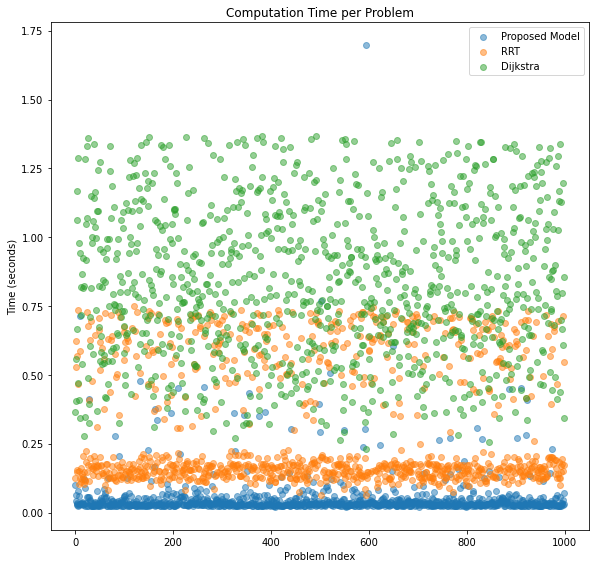

In [42]:
# Creating a scatter plot for collisions
plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.scatter(range(len(kuka_c_original)), kuka_c_original, alpha=0.5, label='Baseline Model')
# plt.scatter(range(len(kuka_c)), kuka_c, alpha=0.5, label='Proposed Model')
# plt.title('Collisions per Problem')
# plt.xlabel('Problem Index')
# plt.ylabel('Number of Collisions')
# plt.legend()

# Creating a scatter plot for computation time
plt.subplot(1, 2, 2)
# plt.scatter(range(len(kuka_time_original)), kuka_time_original, alpha=0.5, label='Baseline Model')
plt.scatter(range(len(kuka_time)), kuka_time, alpha=0.5, label='Proposed Model')
plt.scatter(range(len(kuka_time_rrt)), kuka_time_rrt, alpha=0.5, label='RRT')
plt.scatter(range(len(kuka_time_dk)), kuka_time_dk, alpha=0.5, label='Dijkstra')
plt.title('Computation Time per Problem')
plt.xlabel('Problem Index')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

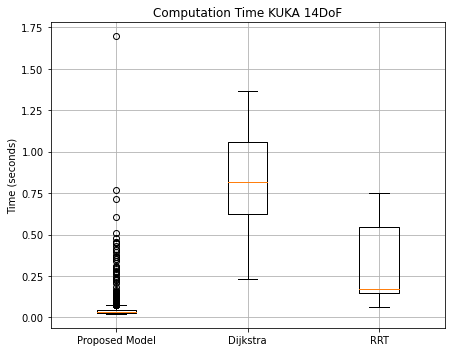

In [43]:

# data_to_plot_time = [kuka_time_original, kuka_time, kuka_time_dk, kuka_time_rrt]
# labels = ['Baseline Model', 'Proposed Model', 'Dijkstra', 'RRT']

data_to_plot_time = [ kuka_time, kuka_time_dk, kuka_time_rrt]
labels = [ 'Proposed Model', 'Dijkstra', 'RRT']


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.boxplot(data_to_plot_time, labels=labels)
plt.title('Computation Time KUKA 14DoF')
plt.ylabel('Time (seconds)')
plt.grid(True)

data_to_plot = [kuka_c_original, kuka_c]
labels = ['Baseline Model', 'Proposed Model']

# plt.subplot(1, 2, 1)
# plt.boxplot(data_to_plot, labels=labels)
# plt.title('Comparison of Collision Counts KUKA 14DoF')
# plt.ylabel('Number of Collisions')
# plt.grid(True)

plt.tight_layout()
plt.show()

In [79]:
kuka_success = np.array([r['success'] for r in kuka_results])
indexes = np.where(kuka_success == True)[0]
i = indexes[50]

In [83]:
env = Kuka2Env(False)
path = kuka_results[i]['path']
env.init_new_problem(i)
gif = env.plot(path, make_gif=True)
gif_path = './kuka14DoF.gif'  # Set your desired output path here
imageio.mimsave(gif_path, gif, fps=10)  # 'gifs' is the list of frames, fps is frames per second

## Test Maze Environment

### Original Model

In [47]:
bs = 100  # only sample 100 points
maze_results_original = []
env = MazeEnv(dim=2, map_file='maze_files/mazes_hard.npz')
indexes = np.arange(1000)  
# Define Models
model_explore = EncoderProcessDecoder(workspace_size=2, config_size=2, embed_size=32, obs_size=2).to(device)                # model explore
model_smooth = ModelSmoother(workspace_size=env.dim, config_size=env.config_dim, embed_size=128, obs_size=6).to(device)
model_explore_path = './data/improved/maze_2d_Original.pt'
model_explore.load_state_dict(torch.load(model_explore_path, map_location=torch.device("cpu")))                                             # load model explore weights
model_smooth_path = 'data/weights/smooth_2d_attv3.pt'
model_smooth.load_state_dict(torch.load(model_smooth_path, map_location=torch.device("cpu")))
# Test the model in 1000 different problems
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    result = explore(env, model_explore, model_smooth, smooth=True, smoother='none', batch=bs, t_max=bs, k=10) 
    maze_results_original.append(result)

100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


### Proposed Model

In [48]:
bs = 100  # only sample 100 points
maze_results = []
env = MazeEnv(dim=2, map_file='maze_files/mazes_hard.npz')
# Define Models
model_explore = AttentionEncoderProcessDecoder(workspace_size=2, config_size=2, embed_size=32, obs_size=2).to(device)                # model explore
model_smooth = ModelSmoother(workspace_size=env.dim, config_size=env.config_dim, embed_size=128, obs_size=6).to(device)
model_explore_path = './data/improved/maze_2d_MHA.pt'
model_explore.load_state_dict(torch.load(model_explore_path, map_location=torch.device("cpu")))                                             # load model explore weights
model_smooth_path = 'data/weights/smooth_2d_attv3.pt'
model_smooth.load_state_dict(torch.load(model_smooth_path, map_location=torch.device("cpu")))
# Test the model in 1000 different problems
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    result = explore(env, model_explore, model_smooth, smooth=True, smoother='none', batch=bs, t_max=bs, k=10) 
    maze_results.append(result)

  0%|          | 3/1000 [00:00<00:50, 19.60it/s]

100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


### RRT

In [52]:
# Test the model in 1000 different problems
bs = 100  # only sample 100 points
maze_results_rrt = []
maze_results_rrt_time = []
t_max = 1000
env = MazeEnv(dim=2, map_file='maze_files/mazes_hard.npz')
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    t0 = time()
    result = NEXT_plan(
            env=env,
            model=None, # Set model to None to use RRT planner
            T=t_max,
            g_explore_eps=1.,
            stop_when_success=True,
            UCB_type='kde'
        )
    maze_results_rrt.append(result)
    maze_results_rrt_time.append(time()-t0)

100%|██████████| 1000/1000 [03:06<00:00,  5.37it/s]


### Dijkstra

In [53]:
# Test the model in 1000 different problems
maze_time_dk = []
env = MazeEnv(dim=2, map_file='maze_files/mazes_hard.npz')
for i in tqdm(range(1000)):
    env.init_new_problem(i)
    set_random_seed(1234)
    time0 = time()
    points = env.uniform_sample(n=np.random.randint(100, 400))
    edge_cost, neighbors, edge_index, edge_free = construct_graph(env, points)
    dist, prev = dijkstra(list(range(len(points))), neighbors, edge_cost, 0)
    valid_goal = np.logical_and(np.array(list(dist.values())) != INFINITY, np.array(list(dist.values()))!=0)
    # print(valid_goal)
    # goal_index = np.random.choice(len(valid_goal), p=valid_goal.astype(float)/sum(valid_goal))
    maze_time_dk.append(time()-time0)

100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


### Comparison

In [54]:
# Collision numbers
maze_c_original = np.array([r['c_explore'] for r in maze_results_original]) # Collision numbers
maze_c = np.array([r['c_explore'] for r in maze_results]) # Collision numbers
# Time
maze_time_original = np.array([r['total_explore'] for r in maze_results_original])
maze_time = np.array([r['total_explore'] for r in maze_results]) 

maze_time_rrt = np.array(maze_results_rrt_time)

# Dijkstra results
maze_time_dk = np.array(maze_time_dk)


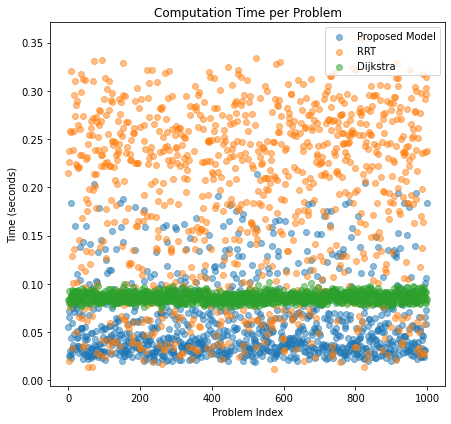

In [56]:
# Creating a scatter plot for collisions
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# # plt.scatter(range(1000), maze_c_original, alpha=0.5, label='Baseline Model')
# plt.scatter(range(1000), maze_c, alpha=0.5, label='Proposed Model')
# plt.title('Collisions per Problem')
# plt.xlabel('Problem Index')
# plt.ylabel('Number of Collisions')
# plt.legend()

# Creating a scatter plot for computation time
plt.subplot(1, 2, 2)
# plt.scatter(range(1000), maze_time_original, alpha=0.5, label='Baseline Model')
plt.scatter(range(1000), maze_time, alpha=0.5, label='Proposed Model')
plt.scatter(range(1000), maze_time_rrt, alpha=0.5, label='RRT')
plt.scatter(range(1000), maze_time_dk, alpha=0.5, label='Dijkstra')
plt.title('Computation Time per Problem')
plt.xlabel('Problem Index')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

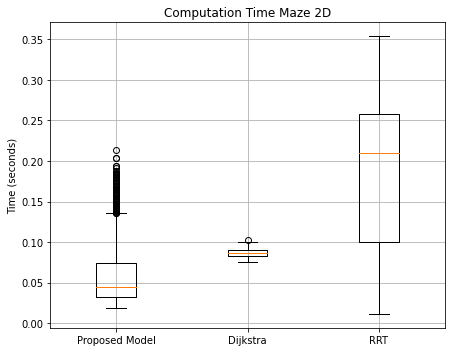

In [57]:
# data_to_plot_time = [maze_time_original, maze_time]
# labels = ['Baseline Model', 'Proposed Model']

data_to_plot_time = [maze_time, maze_time_dk, maze_time_rrt]
labels = ['Proposed Model', 'Dijkstra', 'RRT']


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.boxplot(data_to_plot_time, labels=labels)
plt.title('Computation Time Maze 2D')
plt.ylabel('Time (seconds)')
plt.grid(True)

data_to_plot = [maze_c_original, maze_c]
labels = ['Baseline Model', 'Proposed Model']


# plt.subplot(1, 2, 1)
# plt.boxplot(data_to_plot, labels=labels)
# plt.title('Comparison of Collision Counts Maze 2D')
# plt.ylabel('Number of Collisions')
# plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

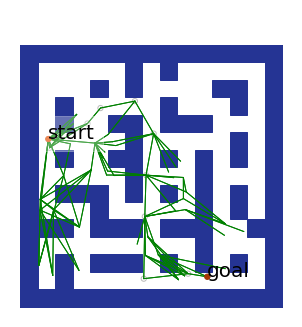

In [71]:
from utilsgnn.plot import plot_edges, plot_graph
i = np.argmax(maze_c) + 1 
env.init_new_problem(i)
edges = maze_results[i]['data'].v[np.array(maze_results[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
plot_edges(maze_results[i]['path'], edges, env.get_problem(), \
           title=' ', \
           save=None)
plt.show()


In [62]:
maze_results[i+1]#['success']

{'c_explore': 578,
 'c_smooth': 0,
 'data': Data(goal=[2], v=[202, 2], labels=[202, 3], edge_index=[2, 3032]),
 'explored': [0,
  22,
  41,
  77,
  84,
  37,
  23,
  83,
  51,
  42,
  52,
  67,
  3,
  70,
  65,
  33,
  88,
  21,
  30,
  9,
  60,
  76,
  80,
  91,
  66,
  85,
  20,
  68,
  27,
  97,
  35,
  89,
  71,
  14,
  93,
  1],
 'forward': 0.010025501251220703,
 'total': 0.07116436958312988,
 'total_explore': 0.07109689712524414,
 'success': True,
 't0': 1701515252.5082345,
 'path': [array([ 0.2903969 , -0.37626976], dtype=float32),
  array([ 0.41199514, -0.7003326 ], dtype=float32),
  array([ 0.7077971 , -0.42587516], dtype=float32),
  array([ 0.80227906, -0.14539243], dtype=float32),
  array([0.83639616, 0.25147334], dtype=float32),
  array([0.8116144, 0.5371665], dtype=float32),
  array([0.5523614, 0.564956 ], dtype=float32),
  array([0.2100222 , 0.50708747], dtype=float32),
  array([0.21335043, 0.6443196 ], dtype=float32),
  array([0.23488341, 0.82424575], dtype=float32),
  a